In [102]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray
import seaborn as sns
import pandas as pd

In [76]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 16
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[3:5],
            1: devices[9:11],
            2: [devices[-2], devices[7]],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def false_free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.s_capacity
            # if load[i] <= self.min_free_space:
            #     self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(122 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(122 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [9]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()
print(architecture.clusters)

for i in range(3):
    for j in executions:
        architecture.heart_beat()
        for h in j:
            architecture.generate(h)
print(architecture.data_allocation)
print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

{0: [3, 4], 1: [9, 10], 2: [16, 7], 3: [0]}
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
122


In [30]:
# 6: [2,4,4,3]
# 10: [3,6,6,5]
# 16: [4.5,9,9,8]
class AcesStepArchitectureEnv(Env):
    def __init__(self, num_stations):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.num_stations = num_stations
        self.multipliers = {
            6: [2,4,4,3],
            10: [3,6,6,5],
            16: [4.5,9,9,8]
        }

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity]

        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)
            self.max_free_space.append(self.architecture.s_capacity)

        self.last_call = [-1]
        self.weight = 0
        self.type = 0
        self.flag = False

        self.observation_space = Dict({
            "weight": Box(low=0, high=5, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-50, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(2,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        self.weight = self.architecture.weights[type] * self.multipliers[self.num_stations][type]
        self.flag = True if self.flag == False else False
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        latency = 0
        alert = False
        computed_latencies = 0
        for location in action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
        for i in range(len(self.free_space)):
            if self.free_space[i] <= self.max_free_space[i]*0.2:
                alert = True

        reward = -1 if alert else 1 - (latency / (computed_latencies * 22+1))

        done = False
        info = {'type': self.type}

        if self.type == 3 and self.flag == False:
            done = True
        if self.type !=3:
            if self.flag == False:
                self.type += 1

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        self.iter = 0
        self.flag=False
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [31]:
ar = AcesStepArchitectureEnv(16)

In [12]:
ar.reset()

{'weight': array([0.05625]),
 'free_space': array([50, 50,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2]),
 'last_calls': array([ 4, -1])}

In [22]:
ar.action_space.sample()

array([8, 6], dtype=int32)

In [32]:
ar.step(ar.action_space.sample())
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(16)
check_env(EnvCompatibility(simulated_aces))

In [33]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(16)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

config["model"]["fcnet_hiddens"] =[64,64]


algorithm_unified_16 = config.build()

result_unified_16 =[]

for j in tqdm(range(50)):
    result_train = algorithm_unified_16.train()["episode_reward_mean"]
    result_unified_16.append(result_train)
    # if (j%100 == 0):
    print(result_train)
print(result_unified_16)

2023-06-22 23:47:52,429	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-22 23:48:03,384	INFO trainable.py:172 -- Trainable.setup took 12.906 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-22 23:48:03,387	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  2%|███▌                                                                                                                                                                           | 1/50 [00:11<09:27, 11.58s/it]

4.069726478768715


  4%|███████                                                                                                                                                                        | 2/50 [00:23<09:22, 11.73s/it]

5.686937737432104


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:35<09:11, 11.73s/it]

5.789127067264913


  8%|██████████████                                                                                                                                                                 | 4/50 [00:46<08:58, 11.70s/it]

5.838743595149969


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:58<08:49, 11.76s/it]

5.88452446677599


 12%|█████████████████████                                                                                                                                                          | 6/50 [01:10<08:36, 11.74s/it]

5.791227046267752


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [01:22<08:24, 11.72s/it]

5.891797739770457


 16%|████████████████████████████                                                                                                                                                   | 8/50 [01:33<08:10, 11.68s/it]

5.941150657280455


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [01:45<07:58, 11.68s/it]

5.989940281928605


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [01:57<07:50, 11.75s/it]

6.031976651826727


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [02:09<07:39, 11.77s/it]

6.079534743732497


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [02:20<07:26, 11.74s/it]

6.090888084711989


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [02:32<07:16, 11.79s/it]

6.124189801560065


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [02:44<07:03, 11.77s/it]

6.1607736329137825


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [02:56<06:54, 11.84s/it]

6.116606788747535


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [03:08<06:43, 11.87s/it]

6.179941482520461


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [03:19<06:29, 11.80s/it]

6.237221055606452


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [03:31<06:19, 11.87s/it]

6.245850049060237


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [03:43<06:07, 11.87s/it]

6.148149402249132


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [03:55<05:55, 11.84s/it]

6.260740898414646


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [04:07<05:44, 11.89s/it]

6.282077639005135


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [04:19<05:35, 11.97s/it]

6.25861499053385


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [04:31<05:20, 11.88s/it]

6.276088610298041


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [04:43<05:09, 11.92s/it]

6.275753393027528


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [04:55<04:57, 11.88s/it]

6.267946486813805


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [05:07<04:44, 11.85s/it]

6.305658481267021


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [05:18<04:32, 11.83s/it]

6.307408674451056


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [05:30<04:19, 11.80s/it]

6.3181945287199195


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [05:42<04:09, 11.89s/it]

6.276956660982109


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [05:54<03:56, 11.83s/it]

6.313422679696493


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [06:05<03:43, 11.77s/it]

6.248662681330655


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [06:17<03:31, 11.74s/it]

6.223444777332001


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [06:29<03:22, 11.89s/it]

6.200031572325868


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [06:41<03:09, 11.83s/it]

6.297353391772572


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [06:53<02:57, 11.81s/it]

6.2318602227407816


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [07:05<02:45, 11.81s/it]

6.157217040048898


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [07:16<02:33, 11.80s/it]

6.328548251825335


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [07:28<02:21, 11.83s/it]

6.316347209734128


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [07:40<02:09, 11.81s/it]

6.310612132849628


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [07:52<01:57, 11.73s/it]

6.292776551373023


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [08:03<01:45, 11.77s/it]

6.206443659906772


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [08:15<01:33, 11.75s/it]

6.185977977815508


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [08:27<01:22, 11.72s/it]

6.24293374933159


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [08:38<01:10, 11.71s/it]

6.255792530378717


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [08:50<00:58, 11.75s/it]

6.271052361019313


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [09:02<00:47, 11.76s/it]

6.317437416994845


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [09:14<00:35, 11.74s/it]

6.298954542897118


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [09:25<00:23, 11.73s/it]

6.258132712819891


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [09:37<00:11, 11.80s/it]

6.302202586189906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:50<00:00, 11.80s/it]

6.2995092400714565
[4.069726478768715, 5.686937737432104, 5.789127067264913, 5.838743595149969, 5.88452446677599, 5.791227046267752, 5.891797739770457, 5.941150657280455, 5.989940281928605, 6.031976651826727, 6.079534743732497, 6.090888084711989, 6.124189801560065, 6.1607736329137825, 6.116606788747535, 6.179941482520461, 6.237221055606452, 6.245850049060237, 6.148149402249132, 6.260740898414646, 6.282077639005135, 6.25861499053385, 6.276088610298041, 6.275753393027528, 6.267946486813805, 6.305658481267021, 6.307408674451056, 6.3181945287199195, 6.276956660982109, 6.313422679696493, 6.248662681330655, 6.223444777332001, 6.200031572325868, 6.297353391772572, 6.2318602227407816, 6.157217040048898, 6.328548251825335, 6.316347209734128, 6.310612132849628, 6.292776551373023, 6.206443659906772, 6.185977977815508, 6.24293374933159, 6.255792530378717, 6.271052361019313, 6.317437416994845, 6.298954542897118, 6.258132712819891, 6.302202586189906, 6.2995092400714565]


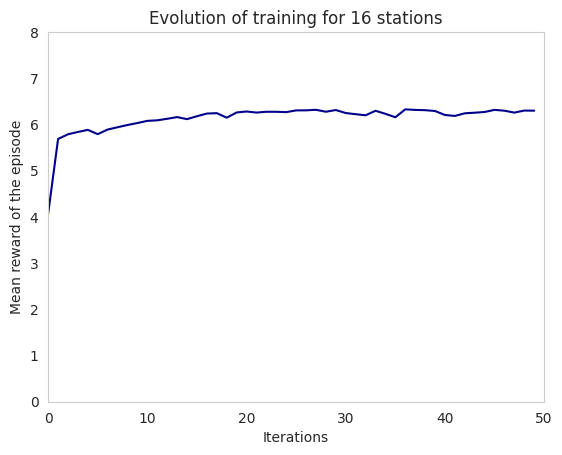

In [128]:
plt.plot(result_unified_16, color='darkblue')
plt.title("Evolution of training for 16 stations")
plt.xlabel("Iterations")
plt.ylabel("Mean reward of the episode")
plt.ylim(0, 8)
plt.xlim(0, 50)
plt.grid(False)

In [112]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(16)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

config["model"]["fcnet_hiddens"] =[64,64]


algorithm_unified_16_100_iters = config.build()

result_unified_16_100_iters =[]

for j in tqdm(range(100)):
    result_train = algorithm_unified_16_100_iters.train()["episode_reward_mean"]
    result_unified_16_100_iters.append(result_train)
    # if (j%100 == 0):
    # print(result_train)
print(result_unified_16_100_iters)

2023-06-23 22:58:32,545	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-23 22:58:44,537	INFO trainable.py:172 -- Trainable.setup took 15.352 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-23 22:58:44,538	WARNING util.py:67 -- Install gputil for GPU system monitoring.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:35<00:00, 11.75s/it]

[3.811898121213514, 5.5863395985863695, 5.640494589646312, 5.684588564127803, 5.583686520024415, 5.737094846185419, 5.79698611435086, 5.842304420128435, 5.899166290363996, 5.949925945799, 5.948556157467337, 6.032804941095243, 6.0860266768690945, 6.097451570243775, 6.0967899019253515, 6.0799401571564955, 6.123978571689885, 5.997905282484741, 6.093639207304, 6.111297382550943, 6.114677493796238, 6.0961841447403895, 6.094028973655902, 6.159799149553808, 6.1363055818353835, 6.026374293398719, 6.058964567637901, 6.031078308237744, 5.773205552402486, 6.0039322385026965, 6.07927854384829, 6.136221557643132, 6.141430754167314, 5.74915313877703, 5.944189006224139, 5.969644086760062, 5.988014752698612, 5.905594459256686, 5.880360704616488, 5.933905888263648, 6.013824378255449, 5.847281010398105, 5.878651060952623, 5.982189987645683, 5.7779326381524525, 5.733185923285442, 5.884712496842614, 5.992199935312088, 6.0038251302457715, 6.09867876052294, 6.1759594408841245, 6.026291616105452, 6.089396190

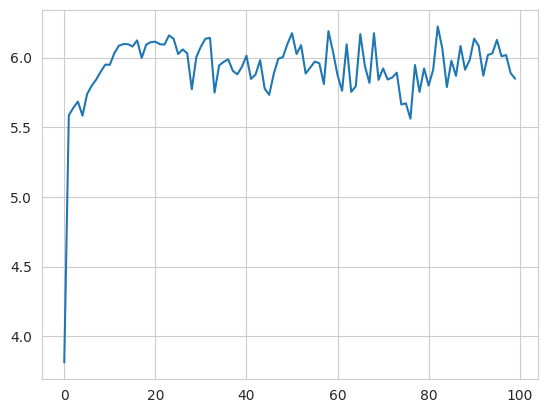

In [113]:
plt.plot(result_unified_16_100_iters)

In [122]:
test_architecture = AcesStepArchitectureEnv(16)
latency_round_robin = []
latency_best_device = []
latency_algorithm = []
free_spaces = []
rewards = []

In [123]:
for i in range(100):
    obs = test_architecture.reset()
    test_architecture.architecture.round_robin()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_round_robin.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_server()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_best_device.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_algorithm()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    # print(test_architecture.architecture.compute_total_latency())
    iteration = {}
    allocation = []
    types = []
    reward = 0

    for i in range(20):
        action = algorithm_unified_16.compute_single_action(obs)
        output = test_architecture.step(action)
        obs = output[0]
        # print(obs['free_space'])
        reward += output[1]
        type = output[3]['type']
        iteration[i] = output[1]
        if type==0:
            for j in range(4):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(0)
                if len(allocation) == 16:
                    for k in range(2):
                        allocation.append(action[k])
                        types.append(0)
        elif type==1:
            for j in range(9):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(1)
        elif type==2:
            for j in range(9):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(2)
        else:
            for j in range(8):
                for k in range(2):
                    if output[1] != -1:
                        allocation.append(action[k])
                        types.append(3)
                    else:
                        allocation.append(random.randint(0,1))
                        types.append(3)
        if output[2]:
            break

    test_architecture.architecture.false_data_allocation = allocation
    test_architecture.architecture.false_data_types = types
    test_architecture.architecture.false_construct_dictionaries()
    # print(iteration)
    latency_algorithm.append(test_architecture.architecture.false_compute_total_latency())
    free_spaces.append(test_architecture.architecture.false_free_space())
    rewards.append(reward)

(0.0, 99.0)

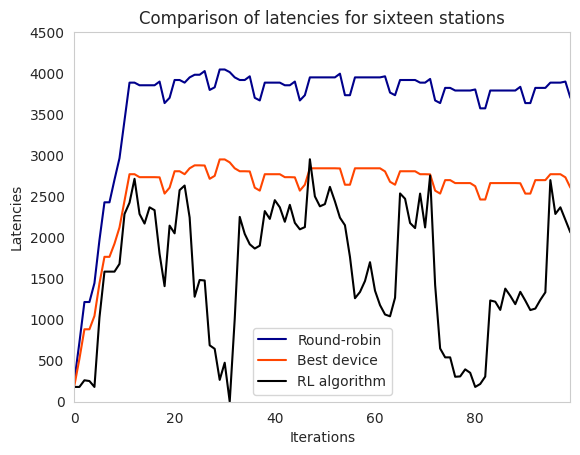

In [124]:
plt.plot(latency_round_robin, color='darkblue', label = "Round-robin")
plt.plot(latency_best_device, color='orangered', label = "Best device")
plt.plot(latency_algorithm, color='black', label = "RL algorithm")
plt.title("Comparison of latencies for sixteen stations")
plt.xlabel("Iterations")
plt.ylabel("Latencies")
plt.legend()
plt.grid(False)
plt.ylim(0, 4500)
plt.xlim(0, 99)

In [109]:
free_space_check = []

for fs_ind in range(len(free_spaces)):
    a=0
    for key in free_spaces[fs_ind].keys():
        if free_spaces[fs_ind][key] <= 0.2:
            a=rewards[fs_ind]
    free_space_check.append(a)

(0.0, 99.0)

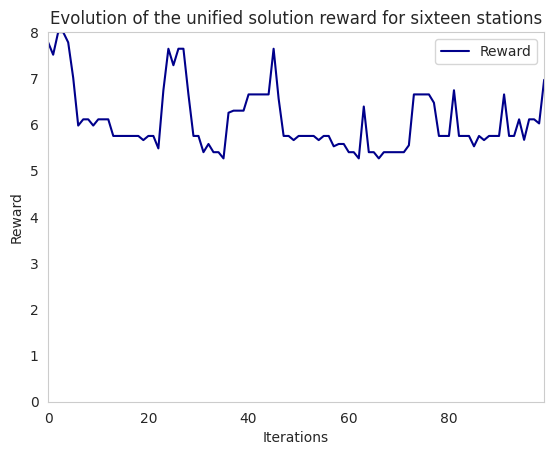

In [110]:
line=plt.plot(rewards, color='darkblue', label = "Reward")
# line=plt.plot(norm_rewards, color='orangered', label = "Normalized reward")
plt.title("Evolution of the unified solution reward for sixteen stations")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend()
plt.grid(False)
plt.ylim(0.0, 8)
plt.xlim(0, 99)

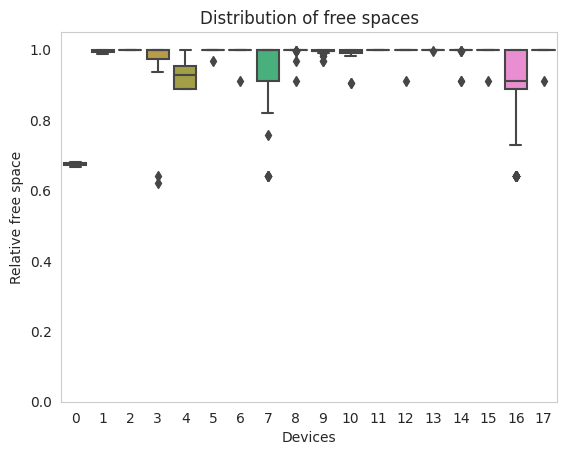

In [111]:
plt.xlim(0, 99)
pre_dataframe = {}
for i in range(18):
    pre_dataframe[i] = []
for fs in free_spaces:
    for key in fs.keys():
        pre_dataframe[key].append(fs[key])
df = pd.DataFrame.from_dict(pre_dataframe)

ax = sns.boxplot(data=df).set(
    title="Distribution of free spaces",
    xlabel="Devices",
    ylabel="Relative free space",
    ylim=(0, 1.05),
)
plt.grid(False)